In [1]:
# Import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from datasets import load_dataset
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm.auto import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import face_recognition
import os
import random
from matplotlib.colors import LinearSegmentedColormap



In [2]:
# Define the number of epochs
epochs = 10

# Define the batch size
batch_size = 16

# Define the input shape
input_shape = (224, 224)

In [3]:
class AffectNetHqDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
def heatmap_generator(image):
    face_locations = face_recognition.face_locations(image)

    # Load the pre-trained facial landmark model
    face_landmarks_list = face_recognition.face_landmarks(image, face_locations)

    h,w = image.shape[:2]
    lm = np.zeros([h,w])

    # Draw facial landmarks on the image
    for face_landmarks in face_landmarks_list:
        for landmark_type, landmarks in face_landmarks.items():
            for (x, y) in landmarks:
                if x < h and y < w :
                    lm[y,x] = 1

    heatmap = cv2.GaussianBlur(lm, [59,59], 3)         

    return heatmap

In [52]:
import torch
import torch.nn as nn

class PrivilegedAttributionLoss(nn.Module):
    def __init__(self):
        super(PrivilegedAttributionLoss, self).__init__()

    def forward(self, attribution_maps, prior_maps):
        # Add a small value to standard deviation to avoid division by zero
        epsilon = 1e-8

        # Calculate mean and standard deviation for each sample in the batch
        mean_al = torch.mean(attribution_maps, dim=[1, 2, 3], keepdim=True)  # Assuming BCHW format
        std_al = torch.std(attribution_maps, dim=[1, 2, 3], keepdim=True) + epsilon

        # Calculate the PAL loss
        # Ensure that the broadcasting in the subtraction and division is correct
        pal_loss = -torch.sum((attribution_maps - mean_al) / std_al * prior_maps, dim=[1, 2, 3])

        # Return the mean loss over the batch
        return torch.mean(pal_loss)


In [6]:
# Load the full dataset
full_dataset = load_dataset("Piro17/affectnethq", split='train')

# Split the dataset into train and test subsets
train_size = int(0.01 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation((-10, 10)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the dataset and dataloader using the subsets
train_dataset = AffectNetHqDataset(Subset(full_dataset, train_subset.indices), transform=train_transform)
test_dataset = AffectNetHqDataset(Subset(full_dataset, test_subset.indices), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Charger le modèle pré-entraîné VGG16
base_model = torchvision.models.vgg16(pretrained=True)
# Supprimer la dernière couche entièrement connectée
base_model.classifier = nn.Sequential(*list(base_model.classifier.children())[:-1])

# Ajouter une nouvelle couche adaptée à 7 classes
num_classes = 7
classifier_layer = nn.Linear(4096, num_classes)
model = nn.Sequential(base_model, classifier_layer)

# Afficher la structure du modèle
summary(model, (3, 224, 224))  # Assurez-vous d'ajuster les dimensions en fonction de vos données

# Identifier la dernière couche de convolution
last_conv_layer = model[0].features[28]
print(last_conv_layer)
optimizer = optim.Adam(model.parameters(), lr=4e-5)

# Fonction pour enregistrer le gradient
def save_gradient(grad):
    global conv_output_gradient
    conv_output_gradient = grad

/opt/homebrew/Caskroom/mambaforge/base/envs/ros_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/ros_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

  0%|          | 0/18 [00:00<?, ?it/s]

error: OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/core/src/arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


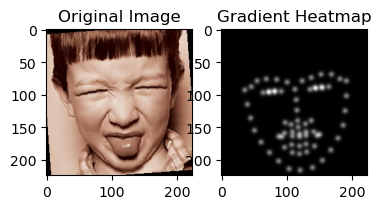

In [55]:
# Attacher un hook pour enregistrer le gradient
from matplotlib.colors import LinearSegmentedColormap

last_conv_layer.register_backward_hook(lambda module, grad_in, grad_out: save_gradient(grad_out[0]))
num_epochs = 1
criterion = torch.nn.CrossEntropyLoss()

# Define the alpha and beta for composite image transparency
alpha = 0.5  # Transparency for the original image
beta = 0.9 # Transparency for the heatmap

# Create a custom colormap
colors = [(0, 0, 0.5), (1, 0, 0)]  # Dark blue to red
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'my_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_pal_loss = 0.0
    running_corrects = 0.0
    total_samples = 0.0
    for images, labels in tqdm(train_loader):

        # Convert the PyTorch tensor to a NumPy array
        cv2_image = images[0].permute(1, 2, 0).cpu().detach().numpy()

        # Ensure the image is in the correct type for OpenCV
        if cv2_image.dtype != np.uint8:
            cv2_image = (cv2_image * 255).astype(np.uint8)

        # Convert from BGR to RGB for face recognition
        cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)

        heatmap = heatmap_generator(cv2_image)
        heatmapa = torch.from_numpy(heatmap).float()

        heatmapa = heatmapa / torch.max(heatmapa)  # Normalize the heatmap

        # Ensure that images require gradients
        images.requires_grad_()

        # Forward pass
        outputs = model(images)
        labels = labels.long()

        # Calcul de la classification loss
        classification_loss = criterion(outputs, labels)

        # Backward pass for gradients with respect to the input images
        classification_loss.backward(retain_graph=True)  # retain_graph=True if you need to call backward again for PAL loss
        gradients = images.grad

        # Compute the attribution maps as the element-wise product of the gradients and the input images
        attribution_maps = gradients * images

        # Compute the PAL loss using the attribution maps and the prior maps
        pal_loss_fn = PrivilegedAttributionLoss()
        pal_loss = pal_loss_fn(attribution_maps, heatmapa)

        # Calcul de la PAL loss et de la classification loss
        total_loss = classification_loss + pal_loss

        # Backpropagation et optimisation
        optimizer.zero_grad()  # Clear gradients before the backward pass
        total_loss.backward()
        optimizer.step()

        # Mise à jour des running loss et PAL loss
        running_loss += classification_loss.item()
        running_pal_loss += pal_loss.item()         

        if epoch == 0 :
            # Visualize the original image
            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB))  # Convertir en RGB pour l'affichage
            plt.title('Original Image')

            # Visualize the heatmap
            plt.subplot(1, 3, 2)
            plt.imshow(heatmap, cmap='gray')
            plt.title('Gradient Heatmap')

            # Préparation de l'image du gradient
            grad_times_input_np = attribution_maps[0].cpu().detach().numpy()  # Use attribution_maps instead of pal_loss
            grad_times_input_rescaled = (grad_times_input_np - grad_times_input_np.min()) / (grad_times_input_np.max() - grad_times_input_np.min())  # Rescale to [0, 1]
            gradient_image = grad_times_input_rescaled.transpose(1, 2, 0)  # Transpose dimensions if needed
            gradient_image_uint8 = np.uint8(255 * gradient_image)  # Convert to 8-bit unsigned integer
            
            # Apply the custom colormap to the gradient image
            gradient_image_colored = plt.cm.ScalarMappable(cmap=cm).to_rgba(gradient_image_uint8, bytes=True)[:,:,:3]

            # Superpose the gradient image on the original image
            composite_image = cv2.addWeighted(cv2_image, alpha, gradient_image_colored, beta, 0)


            # Visualize the composite image
            plt.subplot(1, 3, 3)
            plt.imshow(composite_image)
            plt.title('Composite Image with Gradient Overlay')
            plt.axis("off")
            plt.show()


        # Calcul de la classification loss et de la PAL loss
        total_loss = classification_loss + pal_loss

        # Mise à jour des running loss et PAL loss
        running_loss += classification_loss.item()
        running_pal_loss += pal_loss.item()

        # Calcul de l'accuracy
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

     # Calcul des moyennes pour l'époque
    epoch_loss = running_loss / len(train_loader)
    epoch_pal_loss = running_pal_loss / len(train_loader)
    epoch_acc = running_corrects.double() / total_samples

    # Affichage des résultats
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print(f'Loss: {epoch_loss:.4f}, PAL Loss: {epoch_pal_loss:.4f}, Accuracy: {epoch_acc:.4f}')